In [1]:
# Constants
import string
from random import choices, choice
from datetime import datetime

INPUT_SIZE = [512, 1024, 2048, 4096]
HIDDEN_LAYERS = [1, 2]
HIDDEN_LAYER_DIVISOR = [2, 4, 8]
Z_LAYER_DIVISOR = [4, 8, 16, 32]
DROPOUT = [.1, .25, .5]
LEARNING_RATE = [0.000001, 0.00001, 0.0001]
BATCH_SIZE = [8, 16, 32]
FOLLOWER = True # Set later, false for aae, true for regular

DATA_SET = "Task 3"
TYPE = "Vanilla AE"
TIME_LENGTH = 1 #1
DIFFERENCE_THRESHS = [.8 + 0.2 * i for i in range(25)]
ATTEMPT = 0 # Set later, doesn't make a difference

# New masking section
MASKING = [True, False]
MASK_SIZE = [.25, .5, .75]

name = datetime.now().strftime("%Y%m%d%H%M%S")

model_final_stats = {"name": name, "dataset": DATA_SET, "type": TYPE, "len": TIME_LENGTH}

print(name)

20240228205107


In [2]:
# Assign whether follower or not based on the previous models attempt
import pandas as pd

# Previous failed
previous_failed = False

try:
    open("failed", "x")
except FileExistsError:
    if FOLLOWER:
        crash()
    else:
        previous_failed = True

try:
    previous_trials = pd.read_csv("ae_trials.csv").to_dict("records")
    if len(previous_trials) % 2 == 1:
        print(1)
        FOLLOWER = True
        ATTEMPT = previous_trials[-1]["attempt"]
    elif previous_trials[-1]["attempt"] == 4:
        print(2)
        FOLLOWER = False
        ATTEMPT = 0
    else:
        print(3)
        FOLLOWER = True
        ATTEMPT = previous_trials[-1]["attempt"] + 1
    
    if previous_failed:
        print("Prev Failed")
        FOLLOWER = False
        ATTEMPT = 0
        
        
except (FileNotFoundError, pd.errors.EmptyDataError):
    print(4)
    FOLLOWER = False
    ATTEMPT = 0

model_final_stats["attempt"] = ATTEMPT

1


/tmp/ipykernel_907031/2516016999.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Pick hyperparameters
hyper_params = {
    "input_size": choice(INPUT_SIZE),
    "hidden_layers": choice(HIDDEN_LAYERS),
    "hidden_layers_divisor": choice(HIDDEN_LAYER_DIVISOR),
    "z_layer_divisor": choice(Z_LAYER_DIVISOR),
    "dropout": choice(DROPOUT),
    "learning_rate": choice(LEARNING_RATE),
    "batch_size": choice(BATCH_SIZE),
    "masking": choice(MASKING),
    "mask_size": choice(MASK_SIZE)
}
hyper_params["input_size"] *= TIME_LENGTH
hyper_params["hidden_layers_divisor"] *= TIME_LENGTH
hyper_params["z_layer_divisor"] *= TIME_LENGTH
model_final_stats["leader"] = None

if FOLLOWER:
    previous_models = pd.read_csv("ae_trials.csv", keep_default_na=False).to_dict("records")
    for model in previous_models[::-1]: # We want to find the original leader not a fake leader
        if not model["leader"]:
            model_final_stats["leader"] = model["name"]
            break
    
    for key in hyper_params.keys():
        hyper_params[key] = model[key]

model_final_stats.update(hyper_params)
print(model_final_stats)

{'name': '20240228205107', 'dataset': 'Task 3', 'type': 'Vanilla AE', 'len': 1, 'attempt': 0, 'leader': 20240228204912, 'input_size': 4096, 'hidden_layers': 1, 'hidden_layers_divisor': 4, 'z_layer_divisor': 16, 'dropout': 0.5, 'learning_rate': 0.0001, 'batch_size': 32, 'masking': False, 'mask_size': 0.25}


In [4]:
# Load datasets
from pickle import load
from random import sample

x_tests, y_tests = load(open("data/test_%d_%d.pickle" % (model_final_stats["input_size"], model_final_stats["len"]), "rb"))
x_tests = [[x - 0.5 for x in sample] for sample in x_tests[ATTEMPT]]
y_tests = y_tests[ATTEMPT]

x_train = load(open("data/train_%d_%d.pickle" % (model_final_stats["input_size"], model_final_stats["len"]), "rb"))
x_train = [[x - 0.5 for x in sample] for sample in x_train[ATTEMPT]]

# Mask x_tests and y_tests
if hyper_params["masking"]:
    # print(int(hyper_params["input_size"] * hyper_params["mask_size"]), hyper_params["input_size"])
    # print(len(x_tests))
    x_tests = [[x, [x[i] for i in sorted(sample(range(len(x)), int(hyper_params["input_size"] * hyper_params["mask_size"])))]] for x in x_tests]
    x_train = [[x, [x[i] for i in sorted(sample(range(len(x)), int(hyper_params["input_size"] * hyper_params["mask_size"])))]] for x in x_train]

x_tests, y_tests = [x_tests], [y_tests]

In [5]:
# Create encoder model
from tensorflow.keras import models, layers

encoder = models.Sequential()

if hyper_params["masking"]:
    encoder.add(layers.Input(shape=int(hyper_params["input_size"] * hyper_params["mask_size"])))
else:
    encoder.add(layers.Input(shape=hyper_params["input_size"]))

for i in range(hyper_params["hidden_layers"]):
    encoder.add(layers.Dense(hyper_params["input_size"]//(hyper_params["hidden_layers_divisor"] * i + 1), activation="elu"))
    encoder.add(layers.Dropout(hyper_params["dropout"]))
encoder.add(layers.Dense(hyper_params["input_size"]//hyper_params["z_layer_divisor"]))

encoder.summary()

2024-02-28 20:51:07.957666: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-28 20:51:07.997263: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-28 20:51:08.569087: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              16781312  
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               1048832   
                                                                 
Total params: 17830144 (68.02 MB)
Trainable params: 17830144 (68.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-02-28 20:51:09.459713: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 900 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:18:00.0, compute capability: 8.9
2024-02-28 20:51:09.460300: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22196 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


In [6]:
# Create decoder model

decoder = models.Sequential()
decoder.add(layers.Input(hyper_params["input_size"]//hyper_params["z_layer_divisor"]))
for i in list(range(hyper_params["hidden_layers"]))[::-1]:
    decoder.add(layers.Dense(hyper_params["input_size"]//(hyper_params["hidden_layers_divisor"] * i + 1), activation="elu"))
    decoder.add(layers.Dropout(hyper_params["dropout"]))
decoder.add(layers.Dense(hyper_params["input_size"]))

decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4096)              1052672   
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0         
                                                                 
 dense_3 (Dense)             (None, 4096)              16781312  
                                                                 
Total params: 17833984 (68.03 MB)
Trainable params: 17833984 (68.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
# Create autoencoder model

autoencoder = models.Sequential()

if hyper_params["masking"]:
    autoencoder.add(layers.Input(shape=int(hyper_params["input_size"] * hyper_params["mask_size"])))
else:
    autoencoder.add(layers.Input(shape=hyper_params["input_size"]))

autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256)               17830144  
                                                                 
 sequential_1 (Sequential)   (None, 4096)              17833984  
                                                                 
Total params: 35664128 (136.05 MB)
Trainable params: 35664128 (136.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/300


2024-02-28 20:51:10.437024: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-28 20:51:10.486834: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb071ee9da0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-28 20:51:10.486863: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-02-28 20:51:10.486870: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-02-28 20:51:10.494341: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-28 20:51:10.517106: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-02-28 

3/3 [==============================] - 2s 304ms/step - loss: 0.0668 - val_loss: 0.0449
Epoch 2/300
3/3 [==============================] - 0s 79ms/step - loss: 0.0586 - val_loss: 0.0359
Epoch 3/300
3/3 [==============================] - 0s 71ms/step - loss: 0.0472 - val_loss: 0.0268
Epoch 4/300
3/3 [==============================] - 0s 60ms/step - loss: 0.0391 - val_loss: 0.0188
Epoch 5/300
3/3 [==============================] - 0s 65ms/step - loss: 0.0308 - val_loss: 0.0136
Epoch 6/300
3/3 [==============================] - 0s 60ms/step - loss: 0.0248 - val_loss: 0.0109
Epoch 7/300
3/3 [==============================] - 0s 61ms/step - loss: 0.0210 - val_loss: 0.0086
Epoch 8/300
3/3 [==============================] - 0s 60ms/step - loss: 0.0184 - val_loss: 0.0077
Epoch 9/300
3/3 [==============================] - 0s 59ms/step - loss: 0.0168 - val_loss: 0.0070
Epoch 10/300
3/3 [==============================] - 0s 60ms/step - loss: 0.0158 - val_loss: 0.0065
Epoch 11/300
3/3 [============

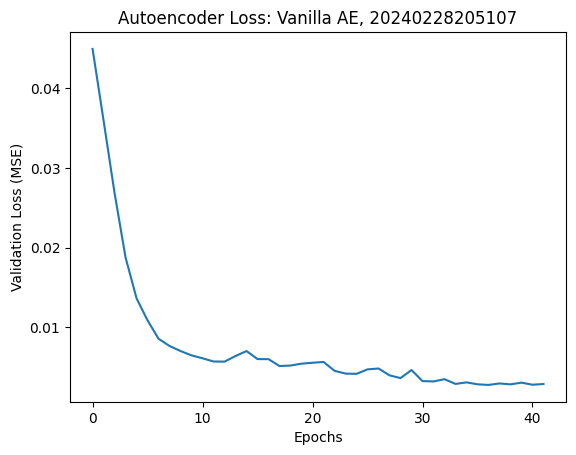

In [8]:
# Fit model and save weights
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
import numpy as np

opt = optimizers.Adam(learning_rate=hyper_params["learning_rate"])
autoencoder.compile(opt, loss="mse")

if hyper_params["masking"]:
    y_train = np.array([x[0] for x in x_train]).reshape(len(x_train), hyper_params["input_size"])
    x_train = np.array([x[1] for x in x_train]).reshape(len(x_train), int(hyper_params["input_size"] * hyper_params["mask_size"]))
    
    fit_run = autoencoder.fit(
        x_train,
        y_train,
        epochs=300,
        batch_size=hyper_params["batch_size"],
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)], validation_split=0.1
    )
else:
    x_train = np.array(x_train).reshape(len(x_train), hyper_params["input_size"])
    
    fit_run = autoencoder.fit(
        x_train,
        x_train,
        epochs=300,
        batch_size=hyper_params["batch_size"],
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)], validation_split=0.1
    )


autoencoder.save_weights("ae_saved/%s" % name)
final_loss = fit_run.history["val_loss"][-1]

ae_res = {"gen_loss": None, "disc_loss": None, "val_loss": fit_run.history["val_loss"][-1], "epochs": len(fit_run.history["val_loss"])}
model_final_stats.update(ae_res)

print(ae_res)
plt.plot(range(len(fit_run.history["val_loss"])), fit_run.history["val_loss"])
plt.title("Autoencoder Loss: %s, %s" % (TYPE, name))
plt.xlabel("Epochs")
plt.ylabel("Validation Loss (MSE)")
plt.show()

In [9]:
# Save splits of z layers, run difference classifier
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from tensorflow.keras.losses import MeanSquaredError
from statistics import mean

mse = MeanSquaredError()

# Copied from latent layer classifiers
def save_results(name, hyper_params, metrics, model_name):
    try:
        previous_trials = pd.read_csv("latent_trials.csv").to_dict("records")
    except (FileNotFoundError, pd.errors.EmptyDataError):
        previous_trials = []

    model_final_stats = {"Classifier": name, "Based on AE": model_name}
    model_final_stats.update(hyper_params)
    
    model_final_stats["precision"] = metrics[0]
    model_final_stats["recall"] = metrics[1]
    model_final_stats["f-score"] = metrics[2]
    
    previous_trials.append(model_final_stats)
    pd.DataFrame(previous_trials).to_csv("latent_trials.csv", index=None)
    
    print(model_final_stats)

for split, x_test, y_test in zip(range(len(x_tests)), x_tests, y_tests):

    if hyper_params["masking"]:
        z_layers = encoder.predict(np.array([x[1] for x in x_test]).reshape(len(x_test), int(hyper_params["input_size"] * hyper_params["mask_size"])))
    else:
        z_layers = encoder.predict(np.array(x_test).reshape(len(x_test), hyper_params["input_size"]))
    
    outputs = decoder.predict(z_layers).tolist()
    print(y_test[0])
    class_true = [[np.argmax(y)] for y in y_test]
    
    z_layers = [y + z.tolist() for z, y in zip(z_layers, class_true)]
    pd.DataFrame(z_layers).to_pickle("z_layers/%s.pickle.gzip" % (name))
    print("Saved z-layers for %s" % split)
    
    for i, sigma in enumerate(DIFFERENCE_THRESHS):
        results = [[], []]
        for y_pred, y_true, y_class in zip(outputs, x_test, class_true):
            results[0].append(y_class)
            results[1].append(1 if mse(y_pred, y_true[0]).numpy() > sigma * final_loss else 0)
        save_results("ReconstructionThreshold", {"sigma": sigma}, list(precision_recall_fscore_support(results[0], results[1], average="binary"))[:3], name)
    print("Done with split %s" % split)

4/4 [==============================] - 0s 1ms/step
(0, 1)
Saved z-layers for 0
{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20240228205107', 'sigma': 0.8, 'precision': 0.27835051546391754, 'recall': 1.0, 'f-score': 0.435483870967742}
{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20240228205107', 'sigma': 1.0, 'precision': 0.27835051546391754, 'recall': 1.0, 'f-score': 0.435483870967742}
{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20240228205107', 'sigma': 1.2000000000000002, 'precision': 0.27835051546391754, 'recall': 1.0, 'f-score': 0.435483870967742}
{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20240228205107', 'sigma': 1.4000000000000001, 'precision': 0.27835051546391754, 'recall': 1.0, 'f-score': 0.435483870967742}
{'Classifier': 'ReconstructionThreshold', 'Based on AE': '20240228205107', 'sigma': 1.6, 'precision': 0.27835051546391754, 'recall': 1.0, 'f-score': 0.435483870967742}
{'Classifier': 'ReconstructionThreshold', 'Based on

1/1 [==============================] - 0s 23ms/step


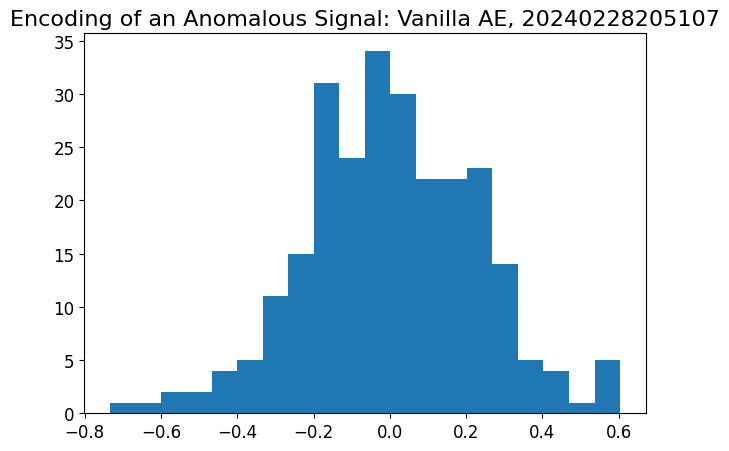

1/1 [==============================] - 0s 21ms/step


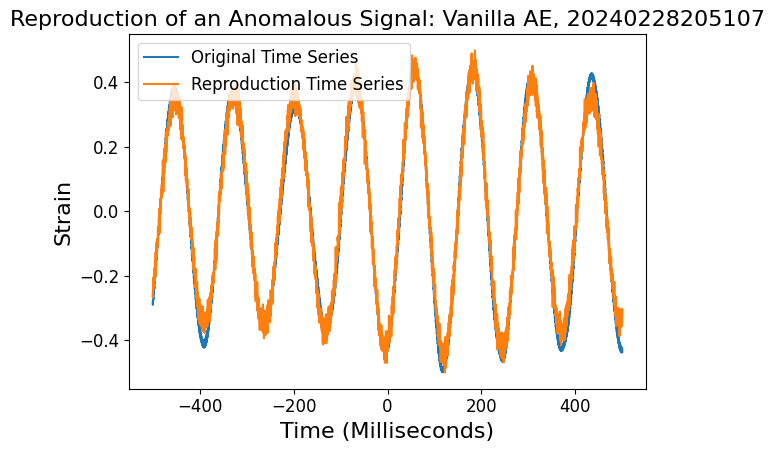

1/1 [==============================] - 0s 17ms/step


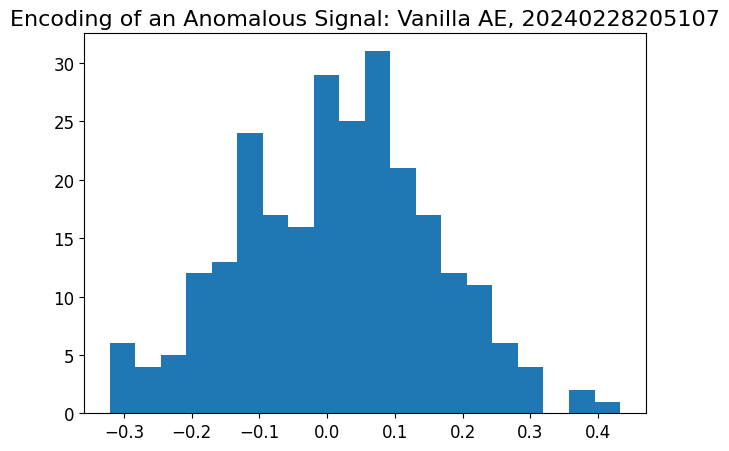

1/1 [==============================] - 0s 17ms/step


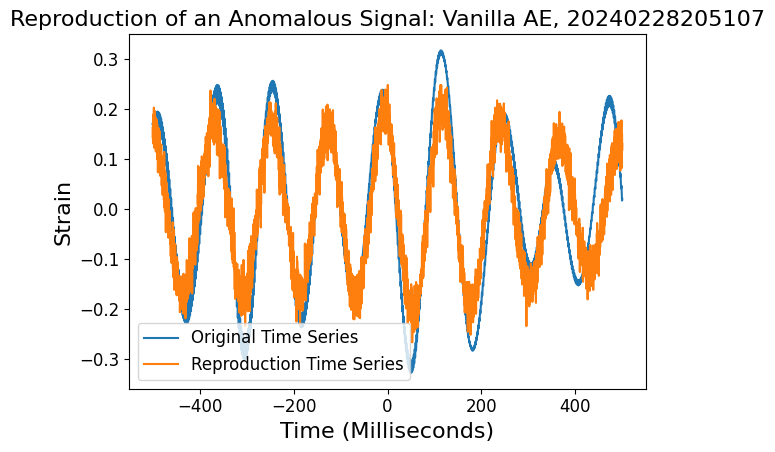

1/1 [==============================] - 0s 18ms/step


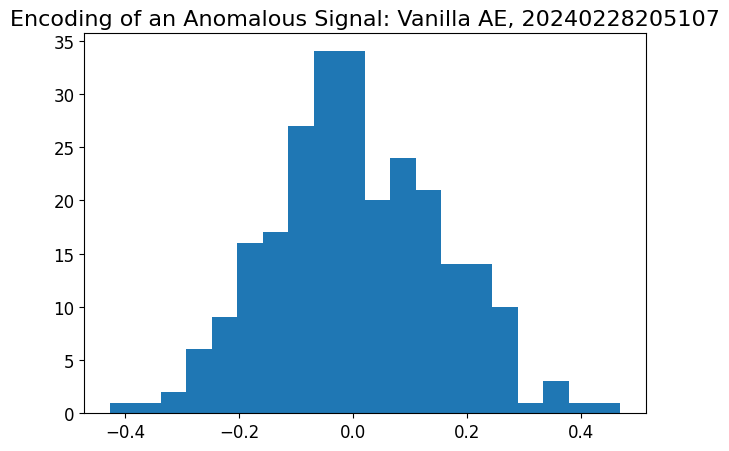

1/1 [==============================] - 0s 17ms/step


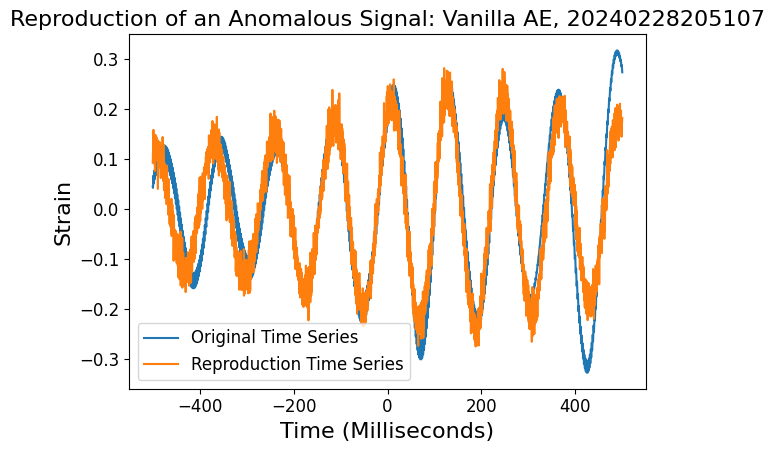

1/1 [==============================] - 0s 17ms/step


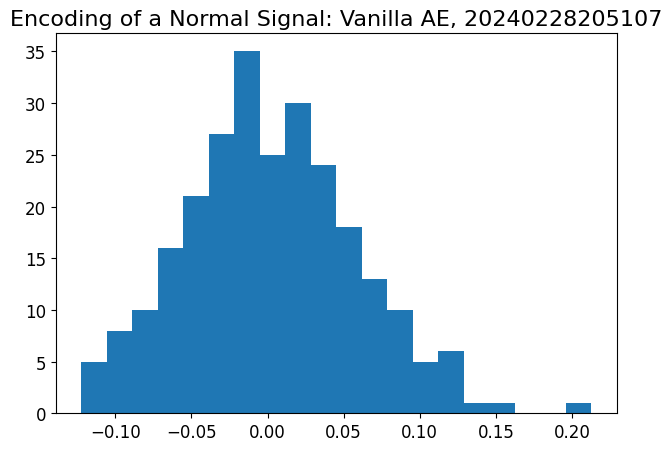

1/1 [==============================] - 0s 17ms/step


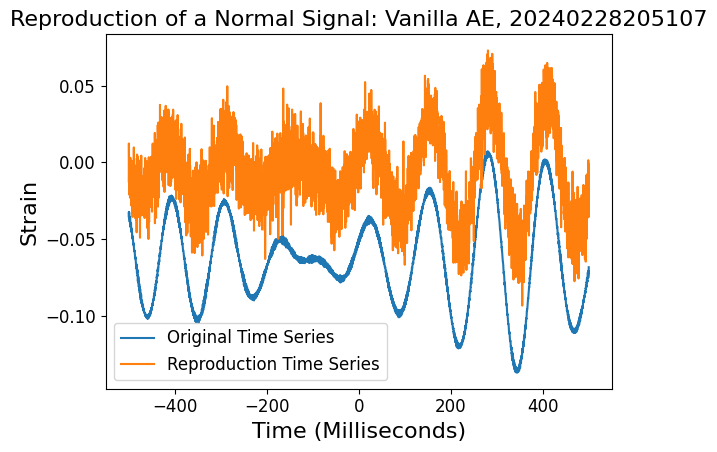

1/1 [==============================] - 0s 17ms/step


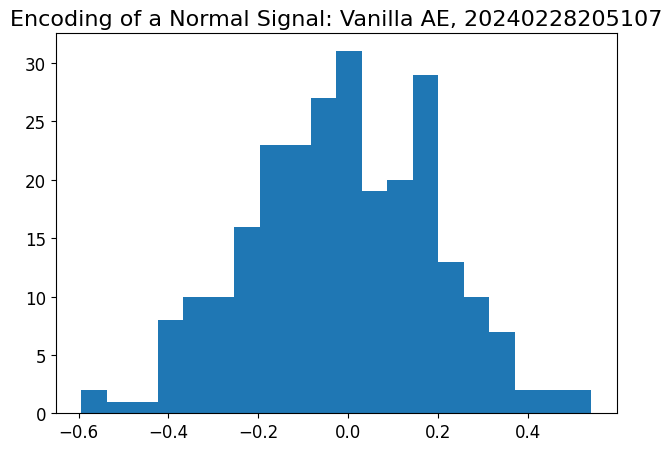

1/1 [==============================] - 0s 17ms/step


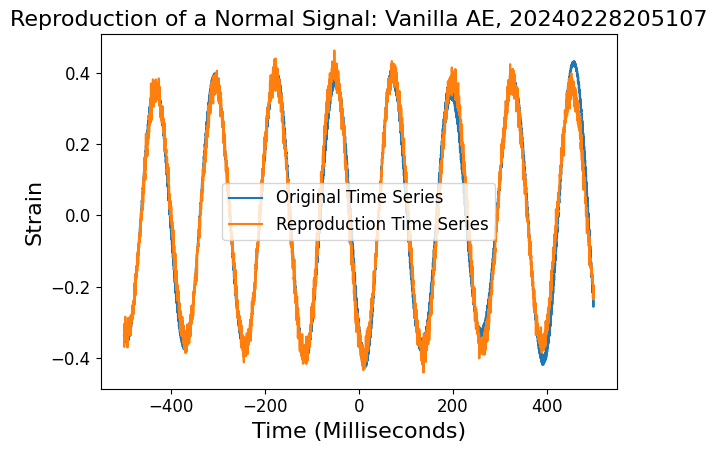

1/1 [==============================] - 0s 17ms/step


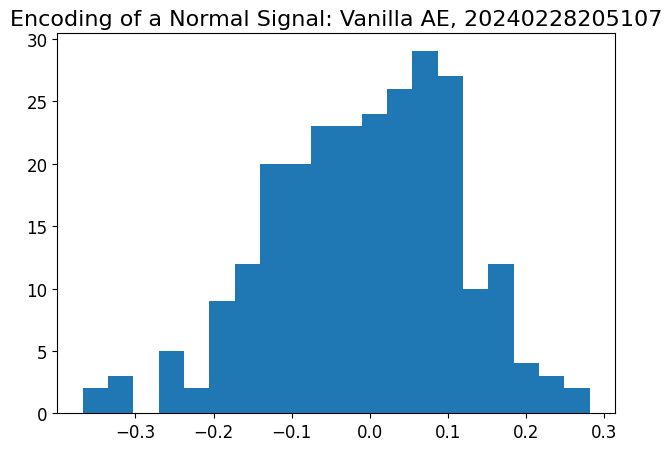

1/1 [==============================] - 0s 17ms/step


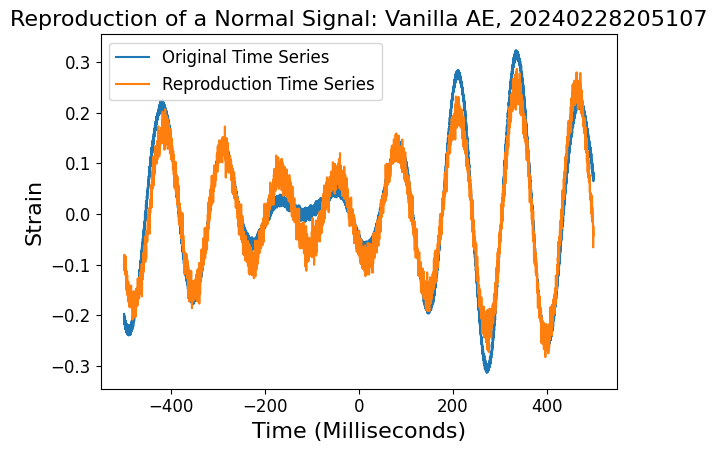

1/1 [==============================] - 0s 17ms/step


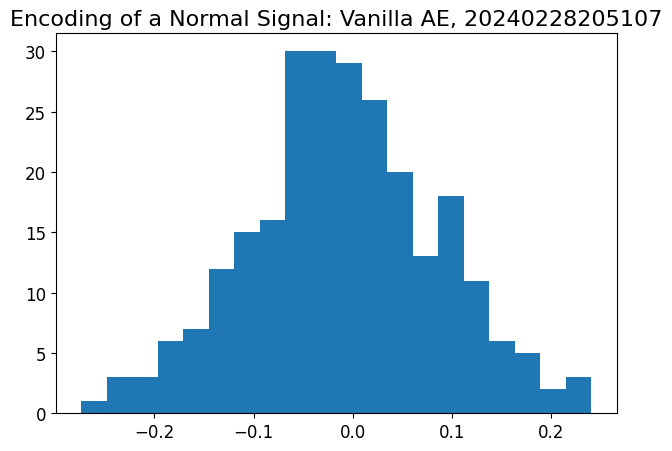

1/1 [==============================] - 0s 17ms/step


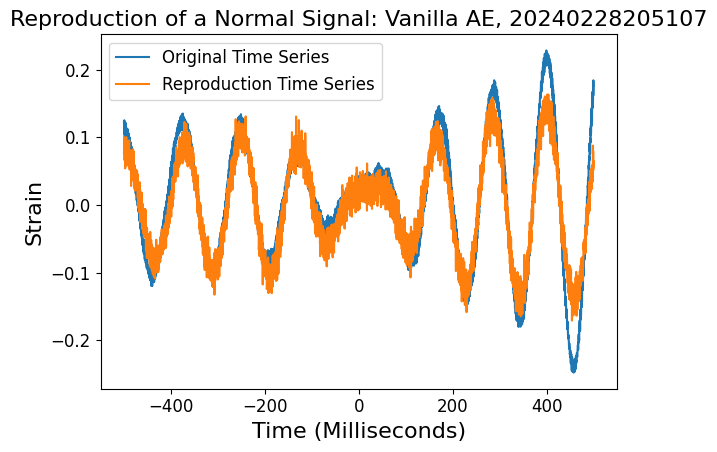

1/1 [==============================] - 0s 17ms/step


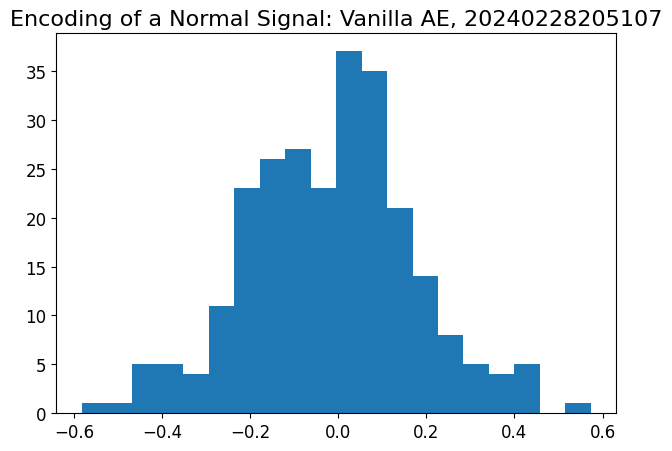

1/1 [==============================] - 0s 17ms/step


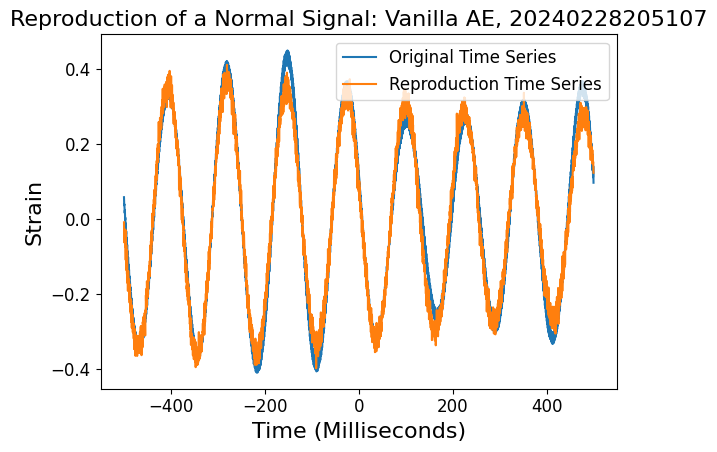

1/1 [==============================] - 0s 17ms/step


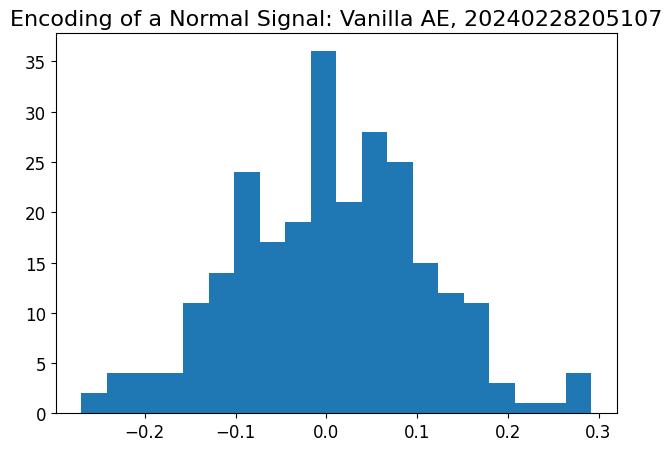

1/1 [==============================] - 0s 17ms/step


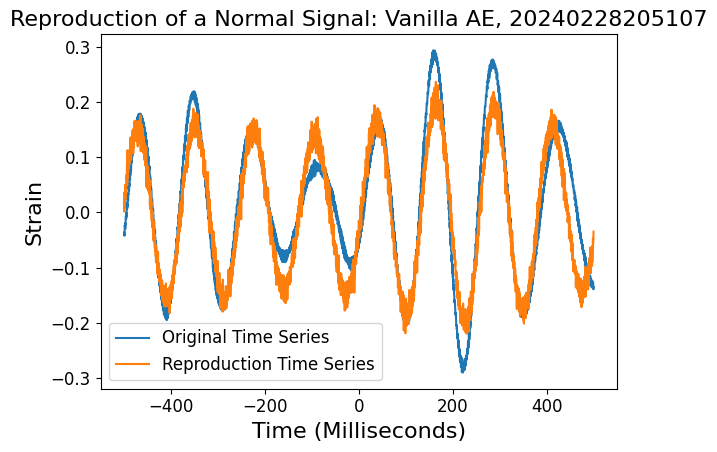

1/1 [==============================] - 0s 17ms/step


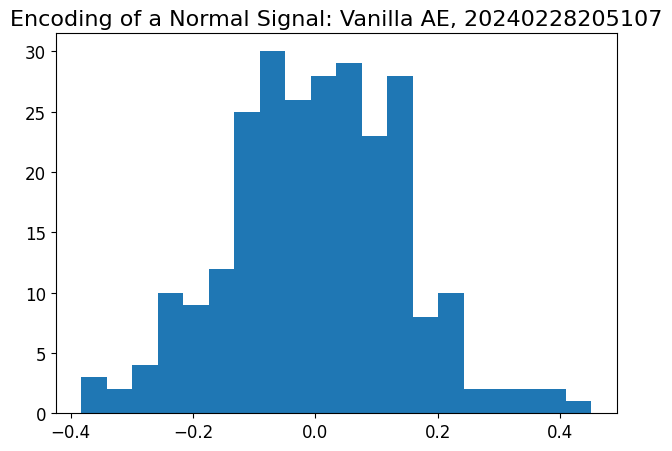

1/1 [==============================] - 0s 18ms/step


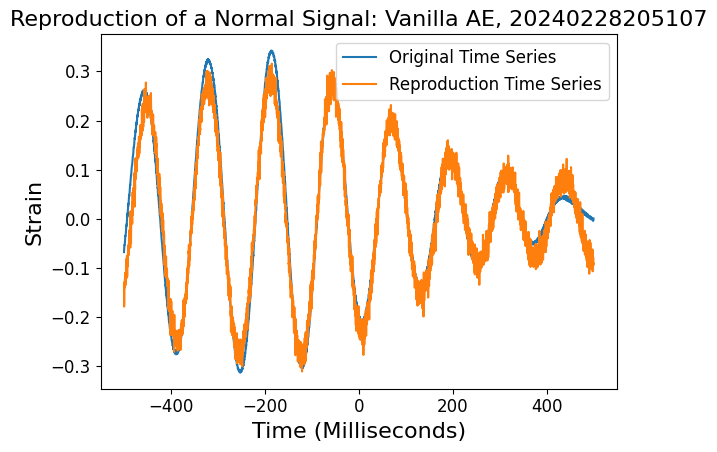

In [10]:
# Plot five graphs
from random import shuffle

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc("font", size=MEDIUM_SIZE)
plt.rc("axes", titlesize=MEDIUM_SIZE, labelsize=MEDIUM_SIZE)
plt.rc("xtick", labelsize=SMALL_SIZE)
plt.rc("ytick", labelsize=SMALL_SIZE)
plt.rc("legend", fontsize=SMALL_SIZE)
plt.rc("figure", titlesize=BIGGER_SIZE)

tests_for_graph = [(x, y) for x, y in zip(x_tests[0], y_tests[0])]
shuffle(tests_for_graph)

for x, y in tests_for_graph[:10]:
    if hyper_params["masking"]:
        encoded_x = encoder.predict(np.array(x[1]).reshape(1, int(hyper_params["input_size"] * hyper_params["mask_size"])))
    else:
        encoded_x = encoder.predict(np.array(x).reshape(1, hyper_params["input_size"]))
    
    plt.hist(encoded_x.tolist()[0], bins=20)
    plt.title("Encoding of a%s: %s, %s" % ("n Anomalous Signal" if np.argmax(y) == 1 else " Normal Signal", TYPE, name))
    plt.tight_layout()
    plt.show()
    
    if hyper_params["masking"]:
        plt.plot([(v - (0.5 * len(x[0])))/4.096 for v in range(len(x[0]))], x[0], label="Original Time Series")
        plt.plot([(v - (0.5 * len(x[0])))/4.096 for v in range(len(x[0]))], decoder.predict(encoded_x).tolist()[0], label="Reproduction Time Series")
    else:
        plt.plot([(v - (0.5 * len(x)))/4.096 for v in range(len(x))], x, label="Original Time Series")
        plt.plot([(v - (0.5 * len(x)))/4.096 for v in range(len(x))], decoder.predict(encoded_x).tolist()[0], label="Reproduction Time Series")
    
    plt.legend()
    plt.title("Reproduction of a%s: %s, %s" % ("n Anomalous Signal" if np.argmax(y) == 1 else " Normal Signal", TYPE, name))
    plt.xlabel("Time (Milliseconds)")
    plt.ylabel("Strain")
    plt.tight_layout()
    plt.show()

In [11]:
# Save data to file

try:
    previous_trials = pd.read_csv("ae_trials.csv").to_dict("records")
except (FileNotFoundError, pd.errors.EmptyDataError):
    previous_trials = []

previous_trials.append(model_final_stats)
pd.DataFrame(previous_trials).to_csv("ae_trials.csv", index=None)

In [12]:
# Remove Temp Lock
import os

os.remove("failed")